In [68]:
import pandas as pd
import numpy as np
import os
import re
import string
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import StrMethodFormatter

from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import itertools
from statsmodels.tsa.arima.model import ARIMA
import os
import warnings
import string
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [69]:
df_fuel_statewide = pd.read_excel('../../../data/raw/ce2.1.st.xlsx', sheet_name="physical units")
df_fuel_statewide

,Data release date: March 2023\nRevised data release date: June 2023,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,CE2.1.ST Annual household site fuel consumptio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Number of housing units (million),Total site energy consumptiona,NaN,NaN,NaN,Average site energy consumptiona\n(per househo...,NaN,NaN,NaN
2,NaN,Total U.S.b,Electricity (billion kWh),Natural gas (billion cf),Propane (million gallons),Fuel oil or kerosene (million gallons),Electricity (kWh),Natural gas (ccf),Propane (gallons),Fuel oil or kerosene (gallons)
3,All homes,123.53,1305.2,4217.4,4280.1,2880.3,10566,563,387,507
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
62,West Virginia ...,0.7,9.4,21.2,18.2,Q,13462,651,200,Q
63,Wisconsin ...,2.39,20.1,125.3,218.9,Q,8432,704,728,Q
64,Wyoming ...,0.23,2.1,15.1,22.1,N,9180,898,929,N
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
fuel = df_fuel_statewide.iloc[12,:]
name = df_fuel_statewide.iloc[2,:]
fuel_statewide = pd.concat([name, fuel], axis=1)
# Extract the first 3 rows
total_fuel = fuel_statewide.iloc[7:10]
total_fuel = total_fuel.reset_index(drop=True)

natural_gas_CT = total_fuel.iat[0,1]
propane_CT = total_fuel.iat[1,1]
oil_CT = total_fuel.iat[2,1]
total_fuel["Emissions factor unit"] = ["g (Gas)/scf","g (Gas)/gallon","g (Gas)/gallon"]
total_fuel["CO2"] = [54.44,5720,10150]
total_fuel["CH4"] = [0,0.27*25,0.41*25]
total_fuel["N2O"] = [0,0.05*298,0.08*298]
total_fuel["Total_EF"]=[54.44,5720+6.75+14.90,10150+10.25+23.84]
total_fuel['EF_household']=total_fuel['Total_EF'] * total_fuel.iloc[:, 1]
total_fuel

,2,12,Emissions factor unit,CO2,CH4,N2O,Total_EF,EF_household
0,Natural gas (ccf),557,g (Gas)/scf,54.44,0.00,0.00,54.44,30323.08
1,Propane (gallons),290,g (Gas)/gallon,5720.00,6.75,14.90,5741.65,1665078.5
2,Fuel oil or kerosene (gallons),629,g (Gas)/gallon,10150.00,10.25,23.84,10184.09,6405792.61


In [71]:
fuel = df_fuel_statewide.iloc[12,:]
name = df_fuel_statewide.iloc[2,:]
fuel_statewide = pd.concat([name, fuel], axis=1)
# Extract the first 3 rows
total_fuel_CT = fuel_statewide.iloc[3:6]
total_fuel_CT = total_fuel_CT.reset_index(drop=True)

total_fuel_CT["Emissions factor unit"] = ["g (Gas)/scf","g (Gas)/gallon","g (Gas)/gallon"]
total_fuel_CT["CO2"] = [54.44*1000,5720,10150]
total_fuel_CT["CH4"] = [0,0.27*25,0.41*25]
total_fuel_CT["N2O"] = [0,0.05*298,0.08*298]
total_fuel_CT["Total_EF"]=[54.44*1000,5720+6.75+14.90,10150+10.25+23.84]
total_fuel_CT['EF_CT']=total_fuel_CT['Total_EF'] * total_fuel_CT.iloc[:, 1]#convert all the unit into million. 
total_fuel_CT

,2,12,Emissions factor unit,CO2,CH4,N2O,Total_EF,EF_CT
0,Natural gas (billion cf),36.9,g (Gas)/scf,54440.0,0.00,0.00,54440.00,2008836.0
1,Propane (million gallons),54.3,g (Gas)/gallon,5720.0,6.75,14.90,5741.65,311771.595
2,Fuel oil or kerosene (million gallons),345.7,g (Gas)/gallon,10150.0,10.25,23.84,10184.09,3520639.913


In [72]:
#importing the town-level data
def process_file(file_path):
    # Load the "Data" sheet from the file
    try:
        df = pd.read_excel(file_path, sheet_name="Data")
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None
    
    relevant_values = ['Utility gas', 'Bottled, tank, or LP gas', 'Fuel oil, kerosene, etc.']
    df = df[df['Unnamed: 0'].isin(relevant_values)]
    df = df[['Unnamed: 0', 'Bridgewater town, Litchfield County, Connecticut', 
             'New Milford town, Litchfield County, Connecticut', 
             'Colchester town, New London County, Connecticut',
             'Lyme town, New London County, Connecticut',
             'Old Lyme town, New London County, Connecticut']]
    df = df.reset_index(drop=True)
    
    # Convert string values to numeric in specified columns
    columns_to_convert = df.columns[1:]
    df[columns_to_convert] = df[columns_to_convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce'))
    
    # Remove specific rows
    #df = df.drop(2)
    
    return df

# Specify the directory containing all the files
directory = '../../../Data/Raw'

# Regular expression pattern to match the filename structure
pattern = re.compile(r'TOWN-ACSDP5Y(\d{4})\.DP04-\d{4}-\d{2}-\d{2}T\d{6}\.xlsx')

# Create an empty dictionary to store processed dataframes
processed_files_town = {}

# Loop through each file in the directory
for filename in os.listdir(directory):
    match = pattern.match(filename)
    if match:
        year = match.group(1)  # Extract the year from the filename
        file_path = os.path.join(directory, filename)
        
        # Process the file
        processed_df = process_file(file_path)
        
        # Store processed dataframe in the dictionary with the year as the key
        if processed_df is not None:
            processed_files_town[year] = processed_df
            
processed_files_town['2010']
#print(df['Unnamed: 0'].unique())

,Unnamed: 0,"Bridgewater town, Litchfield County, Connecticut","New Milford town, Litchfield County, Connecticut","Colchester town, New London County, Connecticut","Lyme town, New London County, Connecticut","Old Lyme town, New London County, Connecticut"
0,Utility gas,8,336,187,0,25
1,"Bottled, tank, or LP gas",19,441,356,39,285
2,"Fuel oil, kerosene, etc.",563,6364,4371,833,2168


In [73]:
#importing the town-level data
def process_file(file_path):
    # Load the "Data" sheet from the file
    try:
        df = pd.read_excel(file_path, sheet_name="Data")
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None
    
    relevant_values = ['Utility gas', 'Bottled, tank, or LP gas', 'Fuel oil, kerosene, etc.']
    df = df[df['Unnamed: 0'].isin(relevant_values)]
    partial_column_names = ['Unnamed: 0','Connecticut', 'Hartford', 'Bridgeport', 'New Haven']
    selected_columns = [col for col in df.columns if any(name in col for name in partial_column_names)]
    df = df[selected_columns]
    
    df.reset_index(drop=True, inplace=True)
    
    
    # Convert string values to numeric in specified columns
    columns_to_convert = df.columns[1:]
    df[columns_to_convert] = df[columns_to_convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce'))
    
    # Remove specific rows
    #df = df.drop(2)
    
    # Reset index after dropping a row
    df.reset_index(drop=True, inplace=True)
    
    return df

# Specify the directory containing all the files
directory = '../../../Data/Raw'

# Regular expression pattern to match the filename structure
pattern = re.compile(r'MSA-ACSDP5Y(\d{4})\.DP04-\d{4}-\d{2}-\d{2}T\d{6}\.xlsx')

# Create an empty dictionary to store processed dataframes
processed_files_MSA = {}

# Loop through each file in the directory
for filename in os.listdir(directory):
    match = pattern.match(filename)
    if match:
        year = match.group(1)  # Extract the year from the filename
        file_path = os.path.join(directory, filename)
        
        # Process the file
        processed_df = process_file(file_path)
        
        # Store processed dataframe in the dictionary with the year as the key
        if processed_df is not None:
            processed_files_MSA[year] = processed_df
            
processed_files_MSA['2010']

,Unnamed: 0,Connecticut,"Bridgeport-Stamford-Norwalk, CT Metro Area","Hartford-West Hartford-East Hartford, CT Metro Area","New Haven-Milford, CT Metro Area"
0,Utility gas,422464,116209,162723,117699
1,"Bottled, tank, or LP gas",37329,6474,13903,7400
2,"Fuel oil, kerosene, etc.",665149,155309,217535,148900


In [74]:
# Create an empty dictionary to store the summed values
BSN = {}
HEM = {}
NHM = {}
CT ={}

# Iterate over the years in the dictionaries
for year in processed_files_town.keys(): 
    # Store the summed values in the new dictionary
    BSN[year] = processed_files_MSA[year]['Bridgeport-Stamford-Norwalk, CT Metro Area']+processed_files_town[year]['Bridgewater town, Litchfield County, Connecticut']+processed_files_town[year]['New Milford town, Litchfield County, Connecticut']
    HEM[year] = processed_files_MSA[year].iloc[:, 3]+processed_files_town[year]['Colchester town, New London County, Connecticut']+processed_files_town[year]['Lyme town, New London County, Connecticut']+processed_files_town[year]['Old Lyme town, New London County, Connecticut']
    NHM[year] = processed_files_MSA[year]['New Haven-Milford, CT Metro Area']
    CT[year] = processed_files_MSA[year]['Connecticut']


In [75]:
# New dictionary to store ratios
BSN_ratios = {}
HEM_ratios = {}
NHM_ratios = {}

# Iterate over the keys of one dictionary (assuming both dictionaries have the same keys)
for year in CT.keys():
    # Perform division for each value and store in ratios dictionary
    BSN_ratios[year] = [bsn_val / ct_val for bsn_val,ct_val in zip(BSN[year],CT[year])]
    
# Iterate over the keys of one dictionary (assuming both dictionaries have the same keys)
for year in CT.keys():
    # Perform division for each value and store in ratios dictionary
    HEM_ratios[year] = [hsn_val / ct_val for hsn_val,ct_val in zip(HEM[year],CT[year])]
    
    
# Iterate over the keys of one dictionary (assuming both dictionaries have the same keys)
for year in CT.keys():
    # Perform division for each value and store in ratios dictionary
    NHM_ratios[year] = [nsn_val / ct_val for nsn_val,ct_val in zip(NHM[year],CT[year])]


In [76]:
#calculate the ratio 
# Multiply each value by 2, 3, and 4 respectively and store the results in a new dictionary
BSN_fuel = {}
multipliers = total_fuel_CT['EF_CT']


# Iterate through each dictionary in BSN
for key, values in BSN_ratios.items():
    # Perform multiplication for each value and store in BSN_fuel
    BSN_fuel[key] = [value * multiplier for value, multiplier in zip(values, multipliers)]


# Dictionary comprehension to sum up each dictionary
summed_BSN = {year: sum(values)/1000000 for year, values in BSN_fuel.items()}
summed_BSN

{'2010': 1.4708443468183656,
 '2011': 1.4741768868756202,
 '2012': 1.4769853864489482,
 '2013': 1.4834741124734516,
 '2014': 1.4925472891539657,
 '2015': 1.5033726300754258,
 '2016': 1.5018813058843403,
 '2017': 1.5060364186330437,
 '2018': 1.5059195965680516,
 '2019': 1.4965141134215836,
 '2020': 1.4921420200321367,
 '2021': 1.4934515368336518}

In [77]:
#calculate the ratio 
# Multiply each value by 2, 3, and 4 respectively and store the results in a new dictionary
HEM_fuel = {}
multipliers = total_fuel_CT['EF_CT']


# Iterate through each dictionary in BSN
for key, values in HEM_ratios.items():
    # Perform multiplication for each value and store in BSN_fuel
    HEM_fuel[key] = [value * multiplier for value, multiplier in zip(values, multipliers)]


# Dictionary comprehension to sum up each dictionary
summed_HEM = {year: sum(values)/1000000 for year, values in HEM_fuel.items()}
summed_HEM

{'2010': 2.086995514271736,
 '2011': 2.0861319830915157,
 '2012': 2.0905753608034314,
 '2013': 2.0814625431158085,
 '2014': 2.0837284822717788,
 '2015': 2.0687341976572053,
 '2016': 2.069733161399297,
 '2017': 2.06528321403108,
 '2018': 2.0621095224808212,
 '2019': 2.0666989950677266,
 '2020': 2.0643536530407496,
 '2021': 2.0666388604318233}

In [78]:
#calculate the ratio 
# Multiply each value by 2, 3, and 4 respectively and store the results in a new dictionary
NHM_fuel = {}
multipliers = total_fuel_CT['EF_CT']


# Iterate through each dictionary in BSN
for key, values in NHM_ratios.items():
    # Perform multiplication for each value and store in BSN_fuel
    NHM_fuel[key] = [value * multiplier for value, multiplier in zip(values, multipliers)]


# Dictionary comprehension to sum up each dictionary
summed_NHM = {year: sum(values)/1000000 for year, values in NHM_fuel.items()}
summed_NHM

{'2010': 1.409598086113887,
 '2011': 1.404364656536879,
 '2012': 1.4008982310092175,
 '2013': 1.395054150040248,
 '2014': 1.3843611409160843,
 '2015': 1.386908320566277,
 '2016': 1.3842093418705683,
 '2017': 1.3779569908124385,
 '2018': 1.377584477137045,
 '2019': 1.3739223269893637,
 '2020': 1.3610208392503595,
 '2021': 1.3612381633316795}

In [79]:
# Create DataFrame
df = pd.DataFrame({'New Haven residential emissions (MMTCO2e)': summed_NHM, 'Hartfored residential emissions (MMTCO2e)': summed_HEM, 'Bridgeport residential emissions (MMTCO2e)': summed_BSN})
df.index.name = 'year'


df.index = pd.to_datetime(df.index, format='%Y')
df.index.freq = 'AS'
df.to_csv('../../../data/tidy/residential-emissions-msa-paper.csv')
df

,New Haven residential emissions (MMTCO2e),Hartfored residential emissions (MMTCO2e),Bridgeport residential emissions (MMTCO2e)
year,,,
2010-01-01,1.409598,2.086996,1.470844
2011-01-01,1.404365,2.086132,1.474177
2012-01-01,1.400898,2.090575,1.476985
2013-01-01,1.395054,2.081463,1.483474
2014-01-01,1.384361,2.083728,1.492547
2015-01-01,1.386908,2.068734,1.503373
2016-01-01,1.384209,2.069733,1.501881
2017-01-01,1.377957,2.065283,1.506036
2018-01-01,1.377584,2.062110,1.505920


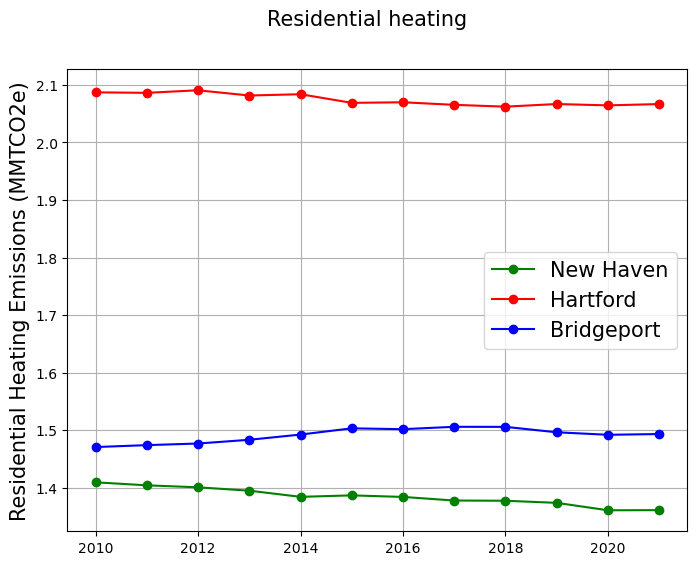

In [80]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Residential heating',fontsize=15)
actual, = plt.plot(df.index, df['New Haven residential emissions (MMTCO2e)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartfored residential emissions (MMTCO2e)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport residential emissions (MMTCO2e)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Residential Heating Emissions (MMTCO2e)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/residential-heating-emissions-historical-change.png', dpi=600, bbox_inches='tight')

In [81]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['New Haven residential emissions (MMTCO2e)'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -0.603680
p-value: 0.870148


In [82]:
adf_test = adfuller(df['Hartfored residential emissions (MMTCO2e)'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -11.489897
p-value: 0.000000


In [83]:
adf_test = adfuller(df['Bridgeport residential emissions (MMTCO2e)'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -35.211271
p-value: 0.000000


In [84]:
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [85]:
len(df_train)

10

In [86]:
len(df_test)

2

In [87]:
HEM_data = df['Hartfored residential emissions (MMTCO2e)']
NHM_data = df['New Haven residential emissions (MMTCO2e)']
BSN_data = df['Bridgeport residential emissions (MMTCO2e)']


warnings.filterwarnings("ignore")

def performance_metric(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = performance_metric(test, pred_mean)
    
    # Calculate BIC and AIC
    bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse, bic

def gridsearch(data): 

    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,5)
    d_values = range(0,1)
    q_values = range(0,5)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                bic_cv = []
            

                split_index = round(len(data)*0.8)
                train = data.iloc[:split_index].copy()
                test = data.iloc[split_index:].copy()

                mape, mae, rmse, bic = arima_prediction(train, test, order)
                mape_cv.append(mape)
                mae_cv.append(mae)
                rmse_cv.append(rmse)
                bic_cv.append(bic)
                    #aic_cv.append(aic)
                    


                # Calculate the mean of metrics across folds
                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean, 'BIC':bic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df

            
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=gridsearch(HEM_data)
results_df_NHM_cv=gridsearch(NHM_data)
results_df_BSN_cv=gridsearch(BSN_data)

print(results_df_HEM_cv)

    p  d  q      MAPE       MAE      RMSE         BIC
0   0  0  0  0.456977  0.009438  0.009507  -53.150589
1   0  0  1  0.378938  0.007827  0.007832  -47.452487
2   0  0  2  0.262452  0.005421  0.005461  -43.195402
3   0  0  3  1.020282  0.021067  0.024031  318.237319
4   0  0  4  0.119828  0.002474  0.003354  -38.981944
5   1  0  0  0.064739  0.001337  0.001734  -60.579740
6   1  0  1  0.405184  0.008371  0.008769  -54.371732
7   1  0  2  0.082717  0.001709  0.001831  -45.304456
8   1  0  3  0.154429  0.003190  0.003274  -41.590132
9   1  0  4  0.097828  0.002020  0.002077  -38.579969
10  2  0  0  0.247382  0.005110  0.005202  -52.953493
11  2  0  1  0.241827  0.004996  0.005126  -50.290225
12  2  0  2  0.009602  0.000198  0.000246  -46.119729
13  2  0  3  0.270876  0.005594  0.005960  -39.509277
14  2  0  4  0.095123  0.001965  0.002220  -37.842223
15  3  0  0  0.009850  0.000203  0.000204  -49.043617
16  3  0  1  0.026267  0.000543  0.000649  -51.080883
17  3  0  2  0.108261  0.002

In [89]:
len(results_df_HEM_cv)

25

In [91]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_HEM=test_HEM.sort_values(by='RMSE').iloc[:23,:]
HEM = sorted_HEM.applymap(lambda x: f'{x:.3f}')
HEM

MAPE    MAE   RMSE      BIC
p d q                              
3 0 0  0.010  0.000  0.000  -49.044
2 0 2  0.010  0.000  0.000  -46.120
3 0 1  0.026  0.001  0.001  -51.081
4 0 4  0.040  0.001  0.001  -44.066
3 0 3  0.061  0.001  0.002  -40.870
1 0 0  0.065  0.001  0.002  -60.580
    2  0.083  0.002  0.002  -45.304
    4  0.098  0.002  0.002  -38.580
2 0 4  0.095  0.002  0.002  -37.842
3 0 2  0.108  0.002  0.003  -52.725
1 0 3  0.154  0.003  0.003  -41.590
0 0 4  0.120  0.002  0.003  -38.982
4 0 0  0.129  0.003  0.003  -44.974
3 0 4  0.165  0.003  0.003  -35.914
4 0 1  0.137  0.003  0.004  -44.014
    2  0.156  0.003  0.004  -44.359
    3  0.181  0.004  0.004  -40.893
2 0 1  0.242  0.005  0.005  -50.290
    0  0.247  0.005  0.005  -52.953
0 0 2  0.262  0.005  0.005  -43.195
2 0 3  0.271  0.006  0.006  -39.509
0 0 1  0.379  0.008  0.008  -47.452
1 0 1  0.405  0.008  0.009  -54.372

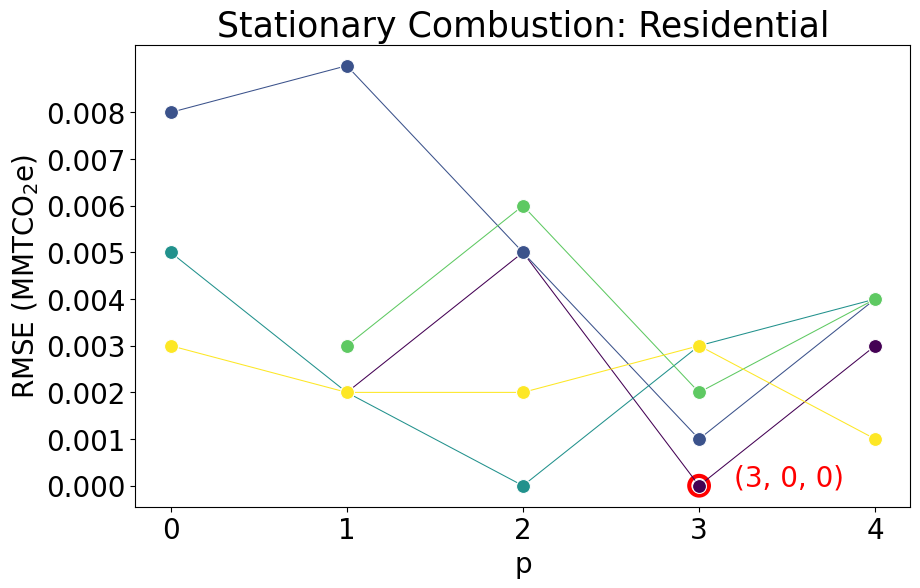

In [113]:
import seaborn as sns

HEM['RMSE'] = pd.to_numeric(HEM['RMSE'], errors='coerce')

# Check for non-numeric values in 'RMSE' column
non_numeric_values = HEM['RMSE'][HEM['RMSE'].apply(lambda x: not np.issubdtype(type(x), np.number))]
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=HEM,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    markers=True,
    style='d',
    legend=False,
    markersize=10
)


# Adding labels and title
plt.title('Stationary Combustion: Residential',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)', fontsize=20)

# Set x-ticks to display years from the start year
plt.xticks(range(8), fontsize=20)


plt.yticks(fontsize=20)  # Set y-ticks and their fontsize
# Customize the y-ticks
maximum = HEM['RMSE'].max()
y_ticks = np.arange(0, maximum, 0.001)  # Create y-ticks with a step of 0.02
plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize


# Annotating the point (1, 2, 0) with a red hollow circle
highlight = HEM.loc[3, 0, 0]
p, d, q = 3, 0, 0  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')
plt.savefig('../../../figures/rmse-plot/stationary_residential_emissions_HEM.jpg', dpi=600, bbox_inches='tight')

In [127]:
test_NHM =results_df_NHM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_NHM=test_NHM.sort_values(by='RMSE').iloc[:23,:]
NHM= sorted_NHM.applymap(lambda x: f'{x:.3f}')
NHM

MAPE    MAE   RMSE      BIC
p d q                              
3 0 2  0.393  0.005  0.006  -44.155
    1  0.410  0.006  0.006  -47.654
2 0 1  0.432  0.006  0.006  -58.693
1 0 2  0.441  0.006  0.006  -50.288
2 0 2  0.449  0.006  0.006  -46.248
1 0 3  0.540  0.007  0.007  -43.093
4 0 3  0.572  0.008  0.008  -33.930
3 0 3  0.581  0.008  0.008  -36.479
2 0 3  0.594  0.008  0.008  -39.126
3 0 4  0.600  0.008  0.008  -43.269
4 0 2  0.646  0.009  0.009  -37.126
    4  0.673  0.009  0.009  -41.034
3 0 0  0.759  0.010  0.010  -55.752
1 0 4  0.758  0.010  0.010  -34.971
    0  0.766  0.010  0.010  -71.162
2 0 0  0.779  0.011  0.011  -61.394
4 0 1  0.817  0.011  0.011  -48.947
1 0 1  0.833  0.011  0.011  -65.731
4 0 0  0.862  0.012  0.012  -45.868
2 0 4  0.877  0.012  0.012  -33.583
0 0 4  1.394  0.019  0.019  -32.922
    1  1.506  0.021  0.021  -52.440
    2  1.723  0.023  0.024  -42.864

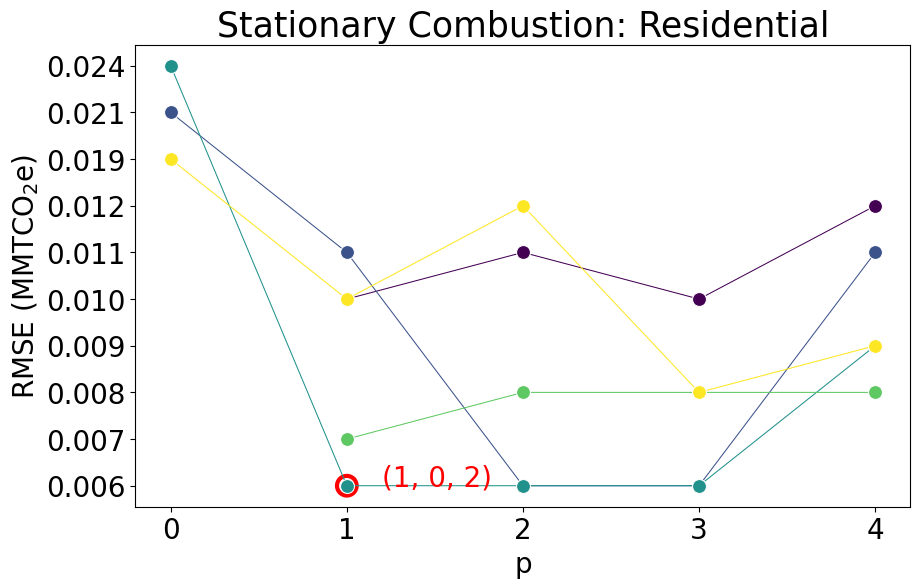

In [128]:
# HEM['RMSE'] = pd.to_numeric(HEM['RMSE'], errors='coerce')

# # Check for non-numeric values in 'RMSE' column
# non_numeric_values = HEM['RMSE'][HEM['RMSE'].apply(lambda x: not np.issubdtype(type(x), np.number))]
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=NHM,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Stationary Combustion: Residential',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)', fontsize=20)

# Set x-ticks to display years from the start year
plt.xticks(range(8), fontsize=20)


plt.yticks(fontsize=20)  # Set y-ticks and their fontsize
# Customize the y-ticks
# maximum = NHM['RMSE'].max()
# y_ticks = np.arange(0, maximum, 0.001)  # Create y-ticks with a step of 0.02
# plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize


# Annotating the point (1, 2, 0) with a red hollow circle
highlight = NHM.loc[1, 0, 2]
p, d, q = 1, 0, 2  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')
plt.gca().invert_yaxis() 

plt.savefig('../../../figures/rmse-plot/stationary_residential_emissions_NHM.jpg', dpi=600, bbox_inches='tight')

In [129]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_BSN = test_BSN.sort_values(by='RMSE').iloc[:23,:]
BSN = sorted_BSN.applymap(lambda x: f'{x:.3f}')
BSN

MAPE    MAE   RMSE      BIC
p d q                              
0 0 0  0.044  0.001  0.001  -50.105
2 0 0  0.091  0.001  0.002  -55.162
0 0 1  0.115  0.002  0.002  -49.344
    2  0.170  0.003  0.003  -44.867
3 0 0  0.149  0.002  0.003  -47.232
2 0 2  0.196  0.003  0.003  -47.926
4 0 3  0.184  0.003  0.003  -40.718
0 0 3  0.191  0.003  0.003  262.688
4 0 0  0.200  0.003  0.004  -43.536
1 0 1  0.237  0.004  0.004  -54.098
4 0 1  0.219  0.003  0.004  -46.668
3 0 3  0.261  0.004  0.004  -38.110
    2  0.241  0.004  0.004  -43.474
4 0 2  0.277  0.004  0.005  -44.042
2 0 1  0.308  0.005  0.005  -57.703
    3  0.381  0.006  0.006  -39.967
1 0 0  0.389  0.006  0.006  -63.566
3 0 1  0.458  0.007  0.007  -47.486
4 0 4  0.571  0.009  0.010  -45.338
1 0 2  0.726  0.011  0.011  -47.875
2 0 4  0.740  0.011  0.011  -32.235
1 0 4  0.766  0.011  0.011  -33.792
0 0 4  0.780  0.012  0.012  -34.958

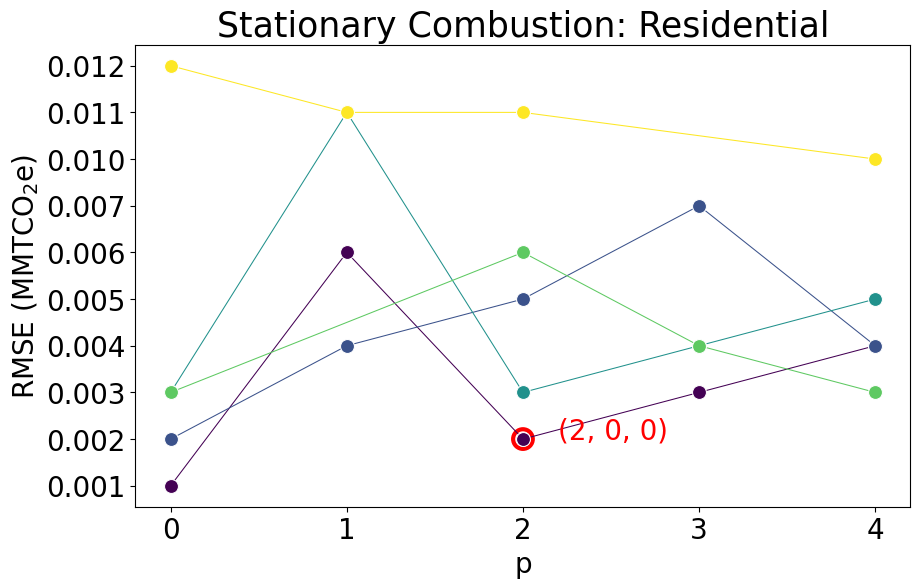

In [130]:
import seaborn as sns
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=BSN,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Stationary Combustion: Residential',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)', fontsize=20)

# Set x-ticks to display years from the start year
plt.xticks(range(8), fontsize=20)


plt.yticks(fontsize=20)  # Set y-ticks and their fontsize
# Customize the y-ticks
# maximum = NHM['RMSE'].max()
# y_ticks = np.arange(0, maximum, 0.001)  # Create y-ticks with a step of 0.02
# plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize


# Annotating the point (1, 2, 0) with a red hollow circle
highlight = BSN.loc[2, 0, 0]
p, d, q = 2, 0, 0  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')
plt.gca().invert_yaxis() 

plt.savefig('../../../figures/rmse-plot/stationary_residential_emissions_BSN.jpg', dpi=600, bbox_inches='tight')

In [ ]:
def arima_forecast(train, test, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2022, 2022 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res,forecast,confidence_interval

HEM_train = df_train['Hartfored residential emissions (MMTCO2e)']
HEM_test = df_test['Hartfored residential emissions (MMTCO2e)']
HEM_data = df['Hartfored residential emissions (MMTCO2e)']
plot_file = '../../../figures/hartford-forecast-emissions-residential.png'  # File to save the plot

HEM_summary,HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data, HEM_test,(3,0,0),14,plot_file,'salmon','orange')
HEM_summary.summary()

In [ ]:
import matplotlib.pyplot as plt

def arima_forecast_1(train, order, forecast_horizon, plot_file, color1, color2):
    # Fit the ARIMA model with the specified order
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Forecasting
    forecast = res.forecast(steps=forecast_horizon)
    forecast.index = range(2023, 2023 + forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')
    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))
    
    # Save the forecast plot
    plt.savefig(plot_file)
    plt.close()
    
    # Impulse Response Calculation
    impulse_responses = res.impulse_responses(steps=forecast_horizon, impulse=0, orthogonalized=False, cumulative=False, anchor='end')
    
    # Ensure the length of impulse_responses matches the forecast_horizon
    impulse_responses = impulse_responses[:forecast_horizon]
    
    return res, forecast, confidence_interval, impulse_responses

def plot_multiple_irfs(irf_data, forecast_horizon, start_year, plot_file):
    plt.figure(figsize=(10, 6))
    
    for region, irf in irf_data.items():
        plt.plot(
            range(0, forecast_horizon),
            irf['impulse_responses'],
            marker=irf.get('marker', 'o'),  # default marker if 'marker' key is missing
            label=f'{region}',
            color=irf.get('color', None),  # default color if 'color' key is missing
            linestyle=irf.get('linestyle', '-'),  # default linestyle if 'linestyle' key is missing
            linewidth=irf.get('linewidth', 2),  # default linewidth if 'linewidth' key is missing
            alpha=irf.get('alpha', 0.7),  # default alpha if 'alpha' key is missing
            markersize=irf.get('markersize', 6)  # default markersize if 'markersize' key is missing
        )
    
    #plt.xlabel('Year', fontsize=20)
    plt.ylabel('Impulse response (MMTCO$_2$e)', fontsize=20)
    plt.xlabel('Forecast year', fontsize=20)
    #plt.legend(fontsize=12)
    plt.title('Stationary Combustion: Residential', fontsize=25)
    plt.grid(True)
    
     # Set x-ticks to display years from the start year
    plt.xticks(range(0, forecast_horizon, 2))
    plt.xticks(fontsize=20)
    
    plt.xticks(fontsize=20) 
    # Set y-ticks to be integers
    max_y = 8  # Replace with your actual maximum value if different
    plt.yticks(range(-4, max_y + 1))
    
    plt.ylim(-4, 8)
    plt.yticks(fontsize=20)
    
    # Adjust the spacing and save the plot
    plt.margins(x=0, y=0)
    plt.savefig(plot_file, dpi=600, bbox_inches='tight')

# Assuming df is your DataFrame and it contains columns for each region
regions = {
    'Hartford': {
         'data': df['Hartfored residential emissions (MMTCO2e)'],
        'order': (3, 0,0),
        'color': 'tomato',
        'marker': 'o',
        'linestyle': '--',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    },
    'New Haven': {
         'data': df['New Haven residential emissions (MMTCO2e)'],
        'order': (1,0,2),
        'color': 'orange',
        'marker': 's',
        'linestyle': '-.',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    },
    'Bridgeport': {
        'data': df['Bridgeport residential emissions (MMTCO2e)'],
        'order': (2, 0,0),
         'color': 'green', 
        'marker': 'x',
        'linestyle': ':',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    }
}


forecast_horizon = 13
start_year = 2023
irf_data = {}

for region, params in regions.items():
    plot_file = f'../../../figures/{region.lower().replace(" ", "")}-forecast-vmt.png'
    summary, forecast, confidence_interval, impulse_responses = arima_forecast_1(params['data'], params['order'], forecast_horizon, plot_file, params['color'], params['color'])
    irf_data[region] = {
        'impulse_responses': impulse_responses,
        'color': params['color'],
        'marker': params['marker'],  # Adding marker information
        'linestyle': params['linestyle'],  # Adding linestyle information
        'linewidth': params['linewidth'],  # Adding linewidth information
        'alpha': params['alpha'],  # Adding alpha information
        'markersize': params['markersize']
    }

irf_plot_file = '../../../figures/impulse-function/residential-IRF.jpg'
plot_multiple_irfs(irf_data, forecast_horizon, start_year, irf_plot_file)

In [ ]:
def arima_test_data_performance_metrics(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2022-len(test),2022)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    return mae, rmse, mape


HEM_train = df_train['Hartfored residential emissions (MMTCO2e)']
HEM_test = df_test['Hartfored residential emissions (MMTCO2e)']
mae, rmse, mape = arima_test_data_performance_metrics(HEM_train, HEM_test,(7,1,6))
print(mae)
print(rmse)
print(mape)

In [ ]:
NHM_train = df_train['New Haven residential emissions (MMTCO2e)']
NHM_test = df_test['New Haven residential emissions (MMTCO2e)']
NHM_data = df['New Haven residential emissions (MMTCO2e)']
plot_file = '../../../figures/newhaven-forecast-emissions-residential.png'  # File to save the plot

summary, NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data, NHM_test, (1,0,2),14, plot_file,'blue','lightblue')#chagne the function name. make function shorter; call old function in new function
summary.summary()

In [ ]:
summary.pvalues

In [ ]:
NHM_train = df_train['New Haven residential emissions (MMTCO2e)']
NHM_test = df_test['New Haven residential emissions (MMTCO2e)']
mae, rmse, mape = arima_test_data_performance_metrics(NHM_train, NHM_test,(5,0,0))
print(mae, rmse, mape)

In [ ]:
BSN_train = df_train['Bridgeport residential emissions (MMTCO2e)']
BSN_test = df_test['Bridgeport residential emissions (MMTCO2e)']
BSN_data = df['Bridgeport residential emissions (MMTCO2e)']
plot_file = '../../../figures/bridgeport-forecast-emissions-residential.png'  # File to save the plot

summary, BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data, BSN_test,(2,0,0),14, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function
summary.summary()

In [ ]:
summary.pvalues

In [ ]:
mae, rmse, mape = arima_test_data_performance_metrics(BSN_train, BSN_test,(0,1,1))
print(mae,rmse, mape)

In [ ]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    train_conf_int = train_forecast.conf_int().iloc[1:]

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()
    
    return train_forecast_mean,train_conf_int
    

emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(3,0,0))
emissions_train_NHM,train_conf_int_NHM=test_train_fitting_VMT(NHM_data,(1,0,2))
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(2,0,0))
    

In [ ]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[2:]
concatenated_predicted_HEM = emissions_train_HEM[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_HEM.index, concatenated_predicted_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

plt.plot(HEM_forecast.index, HEM_forecast, color='lightcoral', label='Hartford_Forecasted',linestyle='--')
plt.fill_between(HEM_forecast.index, HEM_confidence_interval.iloc[:, 0], HEM_confidence_interval.iloc[:, 1], color='lightcoral', alpha=0.3)
plt.fill_between(emissions_train_HEM[1:].index, train_conf_int_HEM.iloc[1:, 0], train_conf_int_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)


concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[2:]
concatenated_predicted_NHM = emissions_train_NHM[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='deepskyblue')
plt.plot(concatenated_predicted_NHM.index, concatenated_predicted_NHM, label='New Haven_Fitted', color='cyan', linestyle='--')

plt.plot(NHM_forecast.index, NHM_forecast, color='darkturquoise', label='New Haven_Forecasted',linestyle='--')
plt.fill_between(NHM_forecast.index, NHM_confidence_interval.iloc[:, 0], NHM_confidence_interval.iloc[:, 1], color='darkturquoise', alpha=0.3)
plt.fill_between(emissions_train_NHM[1:].index, train_conf_int_NHM.iloc[1:, 0], train_conf_int_NHM.iloc[1:, 1], color='darkturquoise', alpha=0.3)

concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[2:]
concatenated_predicted_BSN = emissions_train_BSN[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_BSN.index, concatenated_predicted_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

plt.plot(BSN_forecast.index, BSN_forecast, color='olivedrab', label='Bridgeport_Forecasted',linestyle='--')
plt.fill_between(BSN_forecast.index, BSN_confidence_interval.iloc[:, 0], BSN_confidence_interval.iloc[:, 1], color='olivedrab', alpha=0.3)
plt.fill_between(emissions_train_BSN[1:].index, train_conf_int_BSN.iloc[1:, 0], train_conf_int_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
deepskyblue_patch = mpatches.Patch(color='deepskyblue', label='New Haven Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Historical and forecast residential heating emissions', fontsize=18)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=15, rotation=45) 
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')


plt.savefig('../../../figures/residential_forecast.png', dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM,HEM_forecast])

plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_forecast_HEM.index, concatenated_predicted_forecast_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, HEM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_HEM.index, concatenated_confidence_interval_HEM.iloc[:, 0], concatenated_confidence_interval_HEM.iloc[:, 1], color='lightcoral', alpha=0.3)



concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
concatenated_predicted_forecast_NHM = pd.concat([emissions_train_NHM,NHM_forecast])

plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='orange')
plt.plot(concatenated_predicted_forecast_NHM.index, concatenated_predicted_forecast_NHM, label='New Haven_Fitted', color='orange', linestyle='--')

concatenated_confidence_interval_NHM = pd.concat([train_conf_int_NHM, NHM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_NHM.index, concatenated_confidence_interval_NHM.iloc[:, 0], concatenated_confidence_interval_NHM.iloc[:, 1], color='orange', alpha=0.3)


concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN,BSN_forecast])

plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN.index, concatenated_predicted_forecast_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, BSN_confidence_interval])
plt.fill_between(concatenated_confidence_interval_BSN.index, concatenated_confidence_interval_BSN.iloc[:, 0], concatenated_confidence_interval_BSN.iloc[:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
deepskyblue_patch = mpatches.Patch(color='orange', label='New Haven Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
#plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Stationary Combustion: Residential', fontsize=25)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=20, rotation=45) 
plt.yticks(fontsize=20)
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2021, 1, 1), color='black', linestyle='--', label='Year 2022 (X-axis)')

plt.xlim(datetime.datetime(2011, 1, 1), datetime.datetime(2035, 1, 1))

# Hide the grid lines behind the line plot
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5, zorder=1)

max_y_value = 3
plt.yticks(np.arange(0, max_y_value, 0.5))

plt.savefig('../../../figures/residential_forecast.png', dpi=600, bbox_inches='tight')

In [ ]:
concatenated_predicted_forecast_HEM.index = pd.to_datetime(concatenated_predicted_forecast_HEM.index)
concatenated_observed_HEM.index = pd.to_datetime(concatenated_observed_HEM.index)

# Extract data for the year 2021
HEM_2021 = concatenated_observed_HEM['2021'].values
HEM_2035 = concatenated_predicted_forecast_HEM['2035'].values


concatenated_predicted_forecast_NHM.index = pd.to_datetime(concatenated_predicted_forecast_NHM.index)
concatenated_observed_NHM.index = pd.to_datetime(concatenated_observed_NHM.index)

NHM_2021 = concatenated_observed_NHM['2021'].values
NHM_2035= concatenated_predicted_forecast_NHM['2035'].values


concatenated_predicted_forecast_BSN.index = pd.to_datetime(concatenated_predicted_forecast_BSN.index)
concatenated_observed_BSN.index = pd.to_datetime(concatenated_observed_BSN.index)

# Extract data for the year 2021
BSN_2021 = concatenated_observed_BSN['2021'].values
BSN_2035= concatenated_predicted_forecast_BSN['2035'].values


#how to calculate the difference: the difference equals the (old-new)/old
NHM_per = (NHM_2021-NHM_2035)/NHM_2021*100 #%

HEM_per = (HEM_2021-HEM_2035)/HEM_2021*100 #%

BSN_per = (BSN_2021-BSN_2035)/BSN_2021*100 #%

print(HEM_per,NHM_per,BSN_per)

In [ ]:
df = pd.DataFrame({'Column1': -HEM_per, 'Column2': -NHM_per, 'Column3': -BSN_per})
df

In [ ]:
data = pd.DataFrame({'Column1': HEM_2021, 'Column2': HEM_2035, 'Column3': NHM_2021, 'Column4': NHM_2035, 'Column5': BSN_2021, 'Column6': BSN_2035})
data

In [ ]:
concatenated_confidence_interval_HEM['ME'] = (concatenated_confidence_interval_HEM.iloc[:, 1] - concatenated_confidence_interval_HEM.iloc[:, 0]) / 2
concatenated_confidence_interval_HEM

In [ ]:
concatenated_confidence_interval_NHM['ME'] = (concatenated_confidence_interval_NHM.iloc[:, 1] - concatenated_confidence_interval_NHM.iloc[:, 0]) / 2
concatenated_confidence_interval_NHM

In [ ]:
concatenated_confidence_interval_BSN['ME'] = (concatenated_confidence_interval_BSN.iloc[:, 1] - concatenated_confidence_interval_BSN.iloc[:, 0]) / 2
concatenated_confidence_interval_BSN